## Read data using pandas

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras


SHUFFLE_BUFFER = 500
BATCH_SIZE = 2

csv_file = keras.utils.get_file(
    'heart.csv', 'https://storage.googleapis.com/download.tensorflow.org/data/heart.csv')
    


In [2]:
df: pd.DataFrame = pd.read_csv(csv_file)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [3]:
df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal         object
target        int64
dtype: object

In [4]:
target = df.pop('target')

In [5]:
numeric_feature_names = ['age', 'thalach', 'trestbps',  'chol', 'oldpeak']
numeric_features = df[numeric_feature_names]
numeric_features.head()

,age,thalach,trestbps,chol,oldpeak
0,63,150,145,233,2.3
1,67,108,160,286,1.5
2,67,129,120,229,2.6
3,37,187,130,250,3.5
4,41,172,130,204,1.4


In [6]:
tf.convert_to_tensor(numeric_features, dtype=tf.float32)

<tf.Tensor: shape=(303, 5), dtype=float32, numpy=
array([[ 63. , 150. , 145. , 233. ,   2.3],
       [ 67. , 108. , 160. , 286. ,   1.5],
       [ 67. , 129. , 120. , 229. ,   2.6],
       ...,
       [ 65. , 127. , 135. , 254. ,   2.8],
       [ 48. , 150. , 130. , 256. ,   0. ],
       [ 63. , 154. , 150. , 407. ,   4. ]], dtype=float32)>

In [7]:
normalizer = keras.layers.Normalization(axis=-1)
normalizer.adapt(numeric_features)

In [8]:
normalizer(numeric_features.loc[:3])

<tf.Tensor: shape=(4, 5), dtype=float32, numpy=
array([[ 0.93383914,  0.03480718,  0.74578077, -0.26008663,  1.0680453 ],
       [ 1.3782105 , -1.7806165 ,  1.5923285 ,  0.7573877 ,  0.38022864],
       [ 1.3782105 , -0.87290466, -0.6651321 , -0.33687714,  1.3259765 ],
       [-1.9545751 ,  1.634109  , -0.10076694,  0.06627306,  2.0997703 ]],
      dtype=float32)>

In [9]:
from keras.models import Sequential
from keras.layers import Dense

def get_basic_model():
    model = Sequential([
        normalizer,
        Dense(10, activation='relu'),
        Dense(10, activation='relu'),
        Dense(1),
    ])
    model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])
    return model

In [10]:
model = get_basic_model()
history = model.fit(numeric_features, target, epochs=15, batch_size=BATCH_SIZE)

Epoch 1/15
152/152 [==============================] - 2s 6ms/step - loss: 0.6358 - accuracy: 0.7294
Epoch 2/15
152/152 [==============================] - 1s 6ms/step - loss: 0.5300 - accuracy: 0.7327
Epoch 3/15
152/152 [==============================] - 1s 6ms/step - loss: 0.4806 - accuracy: 0.7426
Epoch 4/15
152/152 [==============================] - 1s 6ms/step - loss: 0.4570 - accuracy: 0.7525
Epoch 5/15
152/152 [==============================] - 1s 6ms/step - loss: 0.4430 - accuracy: 0.7624
Epoch 6/15
152/152 [==============================] - 1s 6ms/step - loss: 0.4379 - accuracy: 0.7822
Epoch 7/15
152/152 [==============================] - 1s 6ms/step - loss: 0.4335 - accuracy: 0.7855
Epoch 8/15
152/152 [==============================] - 1s 8ms/step - loss: 0.4295 - accuracy: 0.7954
Epoch 9/15
152/152 [==============================] - 1s 6ms/step - loss: 0.4263 - accuracy: 0.7855
Epoch 10/15
152/152 [==============================] - 1s 7ms/step - loss: 0.4238 - accuracy: 0.8053

## With tf.data

In [11]:
from tensorflow import data


numeric_dataset = data.Dataset.from_tensor_slices((numeric_features, target))


In [12]:
for row in numeric_dataset.take(3):
    print(row)

(<tf.Tensor: shape=(5,), dtype=float64, numpy=array([ 63. , 150. , 145. , 233. ,   2.3])>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(5,), dtype=float64, numpy=array([ 67. , 108. , 160. , 286. ,   1.5])>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(5,), dtype=float64, numpy=array([ 67. , 129. , 120. , 229. ,   2.6])>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


In [13]:
numeric_batches = numeric_dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(1)

model = get_basic_model()
model.fit(numeric_batches, epochs=15)


Epoch 1/15
152/152 [==============================] - 2s 8ms/step - loss: 0.7276 - accuracy: 0.6997
Epoch 2/15
152/152 [==============================] - 1s 7ms/step - loss: 0.6628 - accuracy: 0.7261
Epoch 3/15
152/152 [==============================] - 1s 8ms/step - loss: 0.5839 - accuracy: 0.7261
Epoch 4/15
152/152 [==============================] - 1s 7ms/step - loss: 0.5030 - accuracy: 0.7261
Epoch 5/15
152/152 [==============================] - 1s 7ms/step - loss: 0.4741 - accuracy: 0.7261
Epoch 6/15
152/152 [==============================] - 1s 8ms/step - loss: 0.4625 - accuracy: 0.7294
Epoch 7/15
152/152 [==============================] - 1s 7ms/step - loss: 0.4541 - accuracy: 0.7459
Epoch 8/15
152/152 [==============================] - 1s 8ms/step - loss: 0.4474 - accuracy: 0.7492
Epoch 9/15
152/152 [==============================] - 1s 9ms/step - loss: 0.4410 - accuracy: 0.7624
Epoch 10/15
152/152 [==============================] - 1s 7ms/step - loss: 0.4377 - accuracy: 0.7657

## DataFrame with heterogeneous data
use dataframe as dict

In [14]:
numeric_dict_ds = tf.data.Dataset.from_tensor_slices((dict(numeric_features), target))


In [15]:
for row in numeric_dict_ds.take(3):
  print(row)

({'age': <tf.Tensor: shape=(), dtype=int64, numpy=63>, 'thalach': <tf.Tensor: shape=(), dtype=int64, numpy=150>, 'trestbps': <tf.Tensor: shape=(), dtype=int64, numpy=145>, 'chol': <tf.Tensor: shape=(), dtype=int64, numpy=233>, 'oldpeak': <tf.Tensor: shape=(), dtype=float64, numpy=2.3>}, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
({'age': <tf.Tensor: shape=(), dtype=int64, numpy=67>, 'thalach': <tf.Tensor: shape=(), dtype=int64, numpy=108>, 'trestbps': <tf.Tensor: shape=(), dtype=int64, numpy=160>, 'chol': <tf.Tensor: shape=(), dtype=int64, numpy=286>, 'oldpeak': <tf.Tensor: shape=(), dtype=float64, numpy=1.5>}, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
({'age': <tf.Tensor: shape=(), dtype=int64, numpy=67>, 'thalach': <tf.Tensor: shape=(), dtype=int64, numpy=129>, 'trestbps': <tf.Tensor: shape=(), dtype=int64, numpy=120>, 'chol': <tf.Tensor: shape=(), dtype=int64, numpy=229>, 'oldpeak': <tf.Tensor: shape=(), dtype=float64, numpy=2.6>}, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


# Dictionaries with Keras

two ways to make Keras model that accepts a dictionary as input
1. subclass tf.keras.Model
2. Keras functional style

In [16]:
def stack_dict(inputs, fun=tf.stack):
    values = []
    for key in sorted(inputs.keys()):
        values.append(tf.cast(inputs[key], tf.float32))
    
    return fun(values, axis=-1)


In [17]:
inputs = {}
for name, column in numeric_features.items():
    inputs[name] = keras.Input(shape=(1,), name=name, dtype=tf.float32)
inputs

{'age': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'age')>,
 'thalach': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'thalach')>,
 'trestbps': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'trestbps')>,
 'chol': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'chol')>,
 'oldpeak': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'oldpeak')>}

In [18]:
x = stack_dict(inputs, fun=tf.concat)

normalizer = keras.layers.Normalization(axis=-1)
normalizer.adapt(stack_dict(dict(numeric_features)))

x = normalizer(x)
x = tf.keras.layers.Dense(10, activation='relu')(x)
x = tf.keras.layers.Dense(10, activation='relu')(x)
x = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(inputs, x)

model.compile(optimizer='adam', 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'],
              run_eagerly=True)


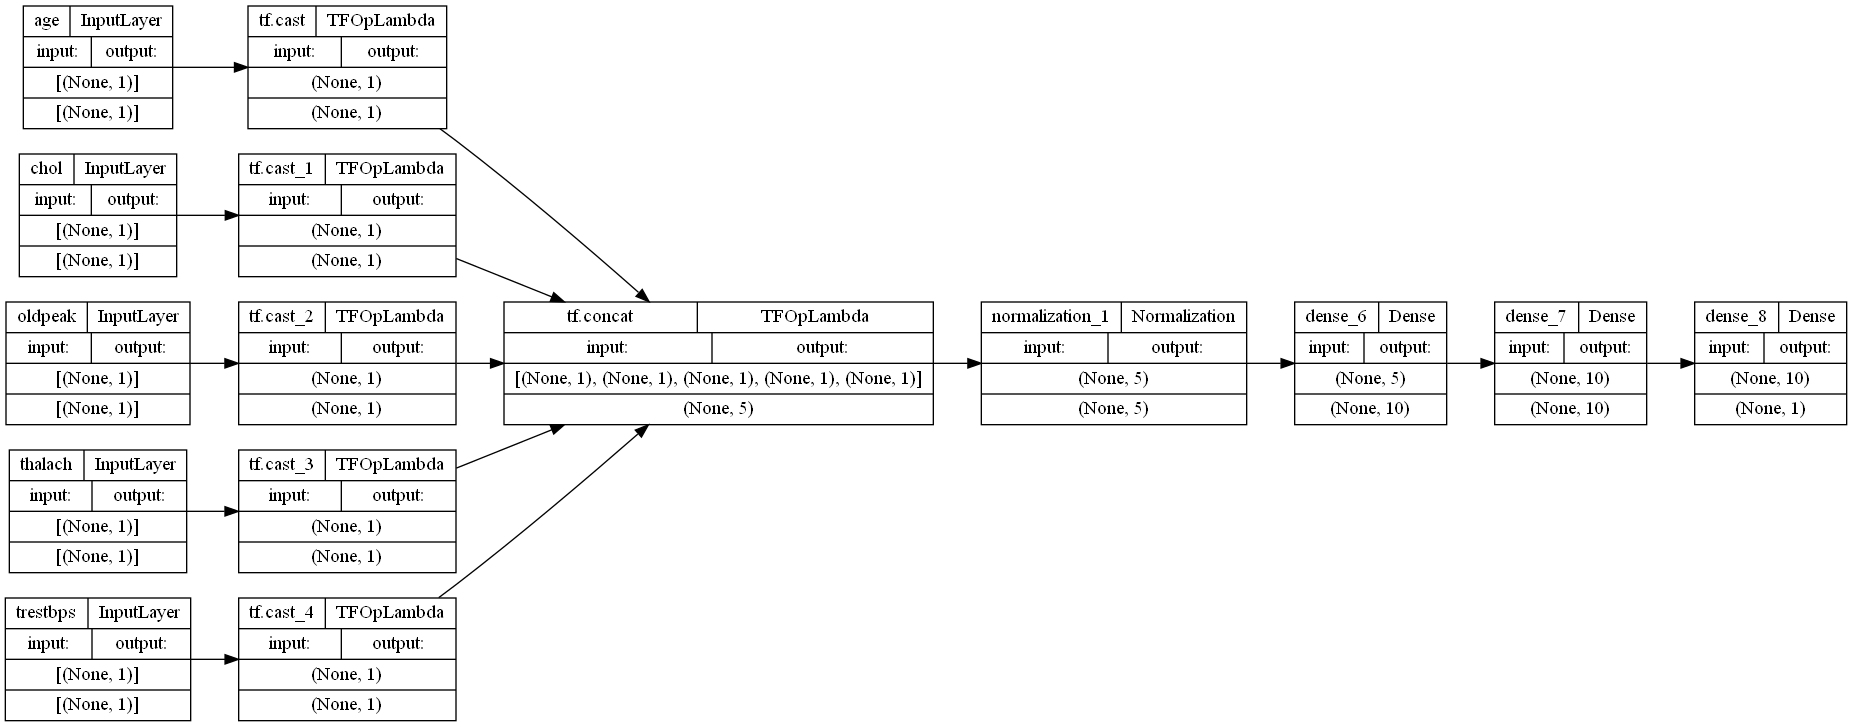

In [19]:
tf.keras.utils.plot_model(model, rankdir='LR', show_shapes=True)

In [20]:
model.fit(dict(numeric_features), target, batch_size=BATCH_SIZE, epochs=5)

Epoch 1/5
152/152 [==============================] - 5s 34ms/step - loss: 0.6683 - accuracy: 0.6964
Epoch 2/5
152/152 [==============================] - 5s 33ms/step - loss: 0.5583 - accuracy: 0.7228
Epoch 3/5
152/152 [==============================] - 6s 36ms/step - loss: 0.5067 - accuracy: 0.7228
Epoch 4/5
152/152 [==============================] - 5s 31ms/step - loss: 0.4768 - accuracy: 0.7360
Epoch 5/5
152/152 [==============================] - 5s 31ms/step - loss: 0.4603 - accuracy: 0.7591


In [21]:
numeric_dict_batches = numeric_dict_ds.shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE).prefetch(2)
model.fit(numeric_dict_batches, epochs=5)

Epoch 1/5
152/152 [==============================] - 5s 33ms/step - loss: 0.4496 - accuracy: 0.7624
Epoch 2/5
152/152 [==============================] - 5s 32ms/step - loss: 0.4421 - accuracy: 0.7690
Epoch 3/5
152/152 [==============================] - 5s 32ms/step - loss: 0.4364 - accuracy: 0.7921
Epoch 4/5
152/152 [==============================] - 6s 36ms/step - loss: 0.4324 - accuracy: 0.7888
Epoch 5/5
152/152 [==============================] - 5s 34ms/step - loss: 0.4289 - accuracy: 0.7855


# Full Example

In [22]:
binary_feature_names = ['sex', 'fbs', 'exang']
categorical_feature_names = ['cp', 'restecg', 'slope', 'thal', 'ca']

inputs = {}
for name, column in df.items():
    if type(column[0]) == str:
        dtype = tf.string
    elif (name in categorical_feature_names or name in binary_feature_names):
        dtype = tf.int64
    else:
        dtype = tf.float32

    inputs[name] = tf.keras.Input(shape=(), name=name, dtype=dtype)
inputs

{'age': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'age')>,
 'sex': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'sex')>,
 'cp': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'cp')>,
 'trestbps': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'trestbps')>,
 'chol': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'chol')>,
 'fbs': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'fbs')>,
 'restecg': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'restecg')>,
 'thalach': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'thalach')>,
 'exang': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'exang')>,
 'oldpeak': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'oldpeak')>,
 'slope': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'slope')>,
 'ca': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'ca')>,
 'thal': <KerasTensor: shape=(None,) dtype=string 

make preprocessor

In [23]:
preprocessed = []

for name in binary_feature_names:
    inp = inputs[name]
    inp = inp[:, tf.newaxis]
    float_value = tf.cast(inp, tf.float32)
    preprocessed.append(float_value)

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(stack_dict(dict(numeric_features)))

numeric_inputs = {}
for name in numeric_feature_names:
    numeric_inputs[name] = inputs[name]

numeric_inputs = stack_dict(numeric_inputs)
numeric_normalized = normalizer(numeric_inputs)

preprocessed.append(numeric_normalized)

for name in categorical_feature_names:
    vocab = sorted(set(df[name]))
    if type(vocab[0]) is str:
        lookup = tf.keras.layers.StringLookup(vocabulary=vocab, output_mode='one_hot')
    else:
        lookup = tf.keras.layers.IntegerLookup(vocabulary=vocab, output_mode='one_hot')
    
    x = inputs[name][:, tf.newaxis]
    x = lookup(x)
    preprocessed.append(x)

In [25]:
preprocessed_result = tf.concat(preprocessed, axis=-1)
preprocessor = tf.keras.Model(inputs, preprocessed_result)

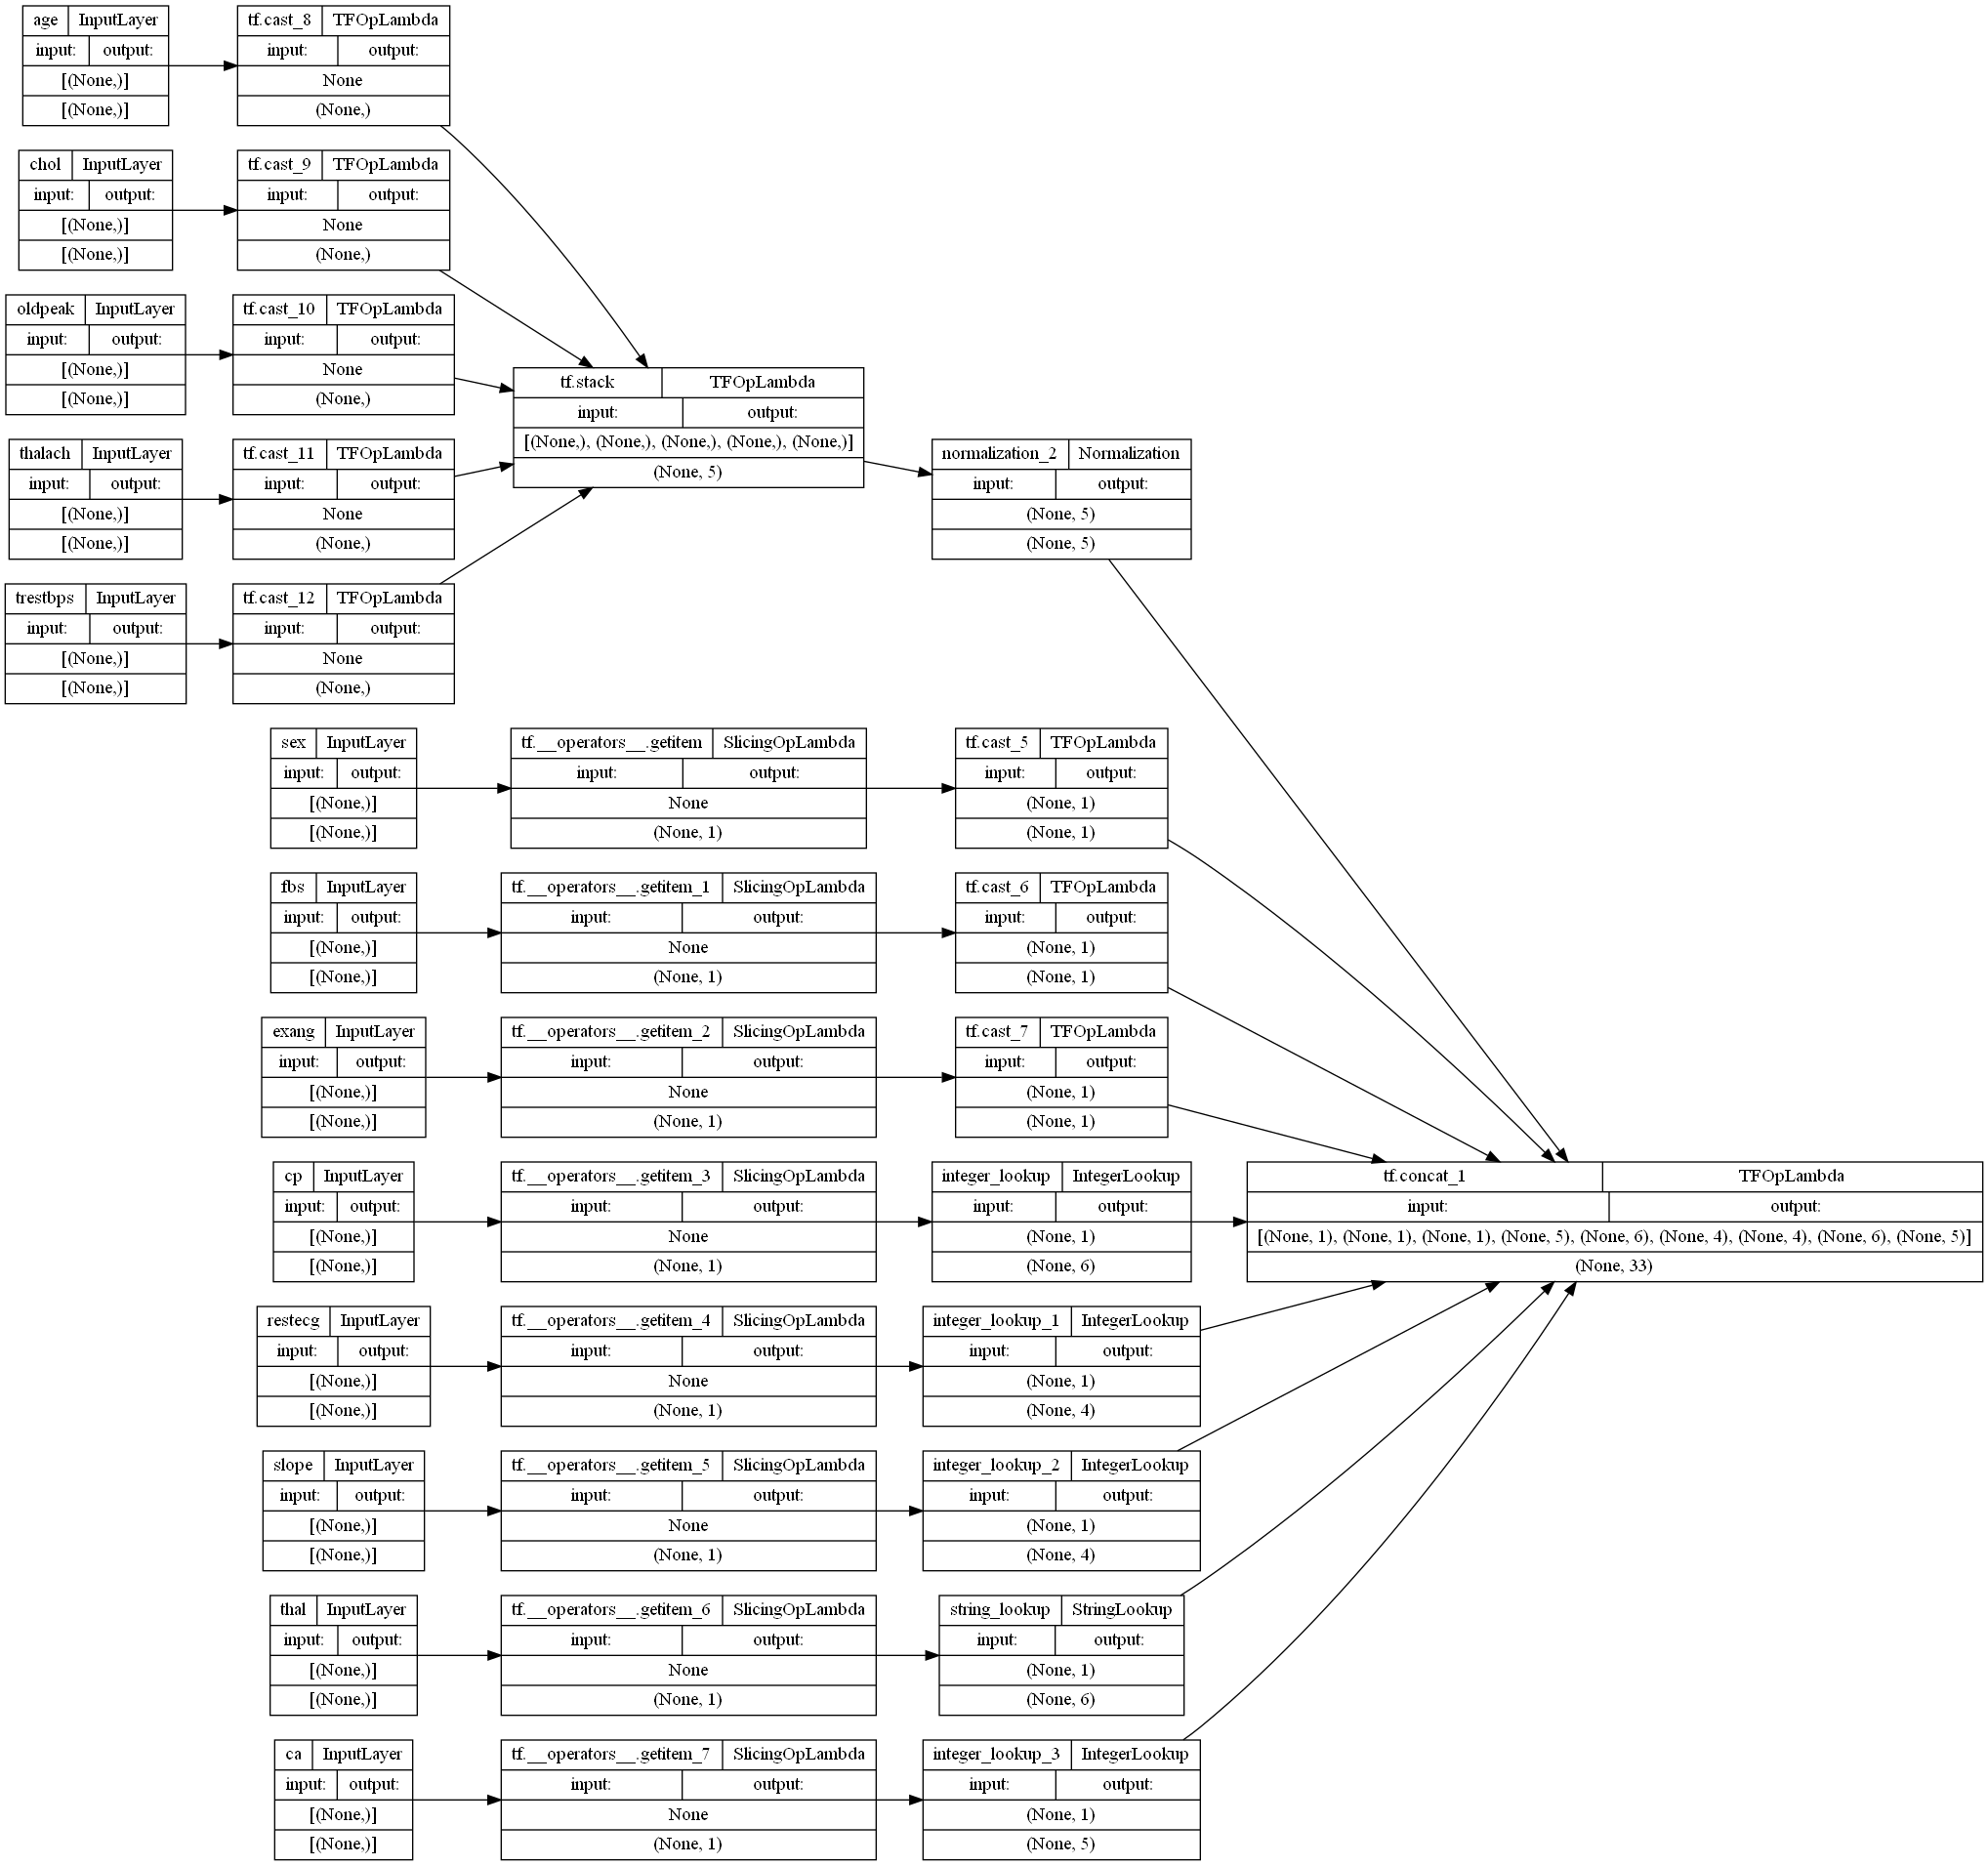

In [26]:
tf.keras.utils.plot_model(preprocessor, rankdir='LR', show_shapes=True)

create and train a model

In [27]:
body = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1),
])

In [28]:
x = preprocessor(inputs)
result = body(x)
model = tf.keras.Model(inputs, result)
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [29]:
history = model.fit(
    dict(df), target, epochs=5, batch_size=BATCH_SIZE
)

Epoch 1/5
152/152 [==============================] - 6s 27ms/step - loss: 0.6606 - accuracy: 0.7261
Epoch 2/5
152/152 [==============================] - 4s 27ms/step - loss: 0.5298 - accuracy: 0.7261
Epoch 3/5
152/152 [==============================] - 4s 29ms/step - loss: 0.4442 - accuracy: 0.7261
Epoch 4/5
152/152 [==============================] - 5s 30ms/step - loss: 0.3982 - accuracy: 0.7261
Epoch 5/5
152/152 [==============================] - 4s 27ms/step - loss: 0.3590 - accuracy: 0.7459


In [30]:
ds = tf.data.Dataset.from_tensor_slices((
    dict(df),
    target
))
ds = ds.batch(BATCH_SIZE)

In [31]:
history = model.fit(ds, epochs=5)

Epoch 1/5
152/152 [==============================] - 5s 28ms/step - loss: 0.3228 - accuracy: 0.8086
Epoch 2/5
152/152 [==============================] - 4s 28ms/step - loss: 0.2976 - accuracy: 0.8383
Epoch 3/5
152/152 [==============================] - 5s 30ms/step - loss: 0.2814 - accuracy: 0.8515
Epoch 4/5
152/152 [==============================] - 5s 30ms/step - loss: 0.2696 - accuracy: 0.8581
Epoch 5/5
152/152 [==============================] - 4s 29ms/step - loss: 0.2600 - accuracy: 0.8779
